# Word Embedding

Obwohl der Korpus lediglich 11000 Texte enthält, wird im Folgenden versucht die Klassifikation auf Basis von Word Embeddings (Kapitel ???) durchzuführen. Dabei kommen verschiedene Klassifikatoren zum Einsatz um zu sehen wie gut diese mit den gegebenen Bedingungen zurecht kommen. Die Wahl fällt auf LSTM, CNNs und deren Kombination.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Pan-Daten-laden" data-toc-modified-id="Pan-Daten-laden-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pan Daten laden</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Ergebnisse-darstellen" data-toc-modified-id="Ergebnisse-darstellen-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ergebnisse darstellen</a></span></li><li><span><a href="#Die-Daten-werden-geladen" data-toc-modified-id="Die-Daten-werden-geladen-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Die Daten werden geladen</a></span><ul class="toc-item"><li><span><a href="#Booksummaries-data" data-toc-modified-id="Booksummaries-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Booksummaries data</a></span></li><li><span><a href="#PAN" data-toc-modified-id="PAN-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>PAN</a></span></li></ul></li><li><span><a href="#Define-model" data-toc-modified-id="Define-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define model</a></span></li><li><span><a href="#Create-dense-model" data-toc-modified-id="Create-dense-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create dense model</a></span></li><li><span><a href="#Create-dense-on-embedded-data" data-toc-modified-id="Create-dense-on-embedded-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Create dense on embedded data</a></span></li><li><span><a href="#Create-lstm-model" data-toc-modified-id="Create-lstm-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Create lstm model</a></span></li><li><span><a href="#Bidirectional-LSTM" data-toc-modified-id="Bidirectional-LSTM-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Bidirectional LSTM</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>CNN</a></span></li><li><span><a href="#CNN-and-LSTM-mixed" data-toc-modified-id="CNN-and-LSTM-mixed-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>CNN and LSTM mixed</a></span></li><li><span><a href="#Compare-pretrained-embedded-layer-with-self-learned-layer" data-toc-modified-id="Compare-pretrained-embedded-layer-with-self-learned-layer-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Compare pretrained embedded layer with self learned layer</a></span></li><li><span><a href="#Train-CNN-LSTM-Model-on-Pan" data-toc-modified-id="Train-CNN-LSTM-Model-on-Pan-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Train CNN-LSTM-Model on Pan</a></span></li></ul></div>

## Dependencies

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals.joblib import Memory

from nltk.tokenize import RegexpTokenizer
import nltk

from nltk.corpus import stopwords
import FEATURE_SELECTOR_v4
import datetime
import json

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, RepeatVector, Bidirectional, GlobalAveragePooling1D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from keras.layers.merge import concatenate
from keras import regularizers
from tensor_board_logger import TensorBoardLogger
#from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras import losses
from keras import metrics
import aatm_support
from keras.models import load_model


[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/julianluebke/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julianluebke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianluebke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/julianluebke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Using TensorFlow backend.


In [2]:
memory = Memory(location='./tmp', verbose=0)

## Pan Daten laden

In [2]:
def load_pan_data(name = 'training'):
    inputDir = f'./datasets/pan18/pan18-style-change-detection-{name}-dataset-2018-01-31'
    
    files = os.listdir(inputDir);
    data = []
    i = 0

    for file in files:
        # for text files only (ignoring truth files)
        if file.endswith(".txt"):
            filePrefix = os.path.splitext(file)[0]
            textFileName = inputDir + "/" + filePrefix + ".txt"
            truthFileName = inputDir + "/" + filePrefix + ".truth"
            
            sample = ['', 0]

            with open(textFileName,encoding="utf8") as textFile:
                sample[0] = textFile.read()
            
            with open(truthFileName) as truthFile:
                sample[1] = int(json.load(truthFile)['changes'])
            
            data.append(sample)
                
            i += 1
    
    return pd.DataFrame(data, columns=['text', 'label'])

## Prepare data

Diese Methode dient dazu die Texte in die gewünschte Form zu bringen, sodass diese anschließend in ein Modell mit einem führenden Embedding-Layer übergeben werden können. Hierfür wird jeder Texte in ein Array mit Integern überführt, wobei jeder Integer-Wert für ein ganz bestimmtes Wort steht. 
Für die weiteren Schritte müssen die Längen der Arrays angeglichen werden. Hierfür wird eine gewünschte Länge vorgegeben. Texte die eine geringere Länge aufweisen werden mittels Padding ergänzt, wobei das Array entweder zu Beginn oder am Ende mit 0-Werten ergänzt werden. Texte, die hingegen zu lang waren, werden gekürzt, indem Wörter weggelassen werden. Als Ergebnis erhält man einen Integermatrix mit m Zeilen und n Spalten, wobei m der Anzahl der Texte und n der festgelegten Länge.

Anschließend wird das Datenset in Trainings- und Testdaten unterteilt.

In [3]:
def prepare_data(tokenizer, serie_texts, labels, max_len=1000, test_size=0.33, random_state=42, max_words=10000):
    """
    Input: 
        tokenizer,
        serie_texts: pd.Series with documents, 
        labels: pd.Series with labels,
        max_len: Length of the array per text after padding,
        test_size: Size of the test set,
        random_state: Random_state
        random_state: random_state
        max_words
    Output: Test and train data
    Method: Tokenizing, Indexing, Padding and splitting into test and train data
    """

    #Tokenizing and Indexing
    sequences = tok.texts_to_sequences(serie_texts)
    #Padding
    sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

    # Split the dataset into test and training data
    X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, labels, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

## Ergebnisse darstellen

In [4]:
def draw_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(1)
    plt.subplot(211)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    acc_values = acc
    val_acc_values = val_acc

    plt.subplot(212)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Die Daten werden geladen


### Booksummaries data

In [5]:
# Path to the data
path_data='.//datasets//constructed_2.csv'

# Load the data
df_texts=pd.read_csv(path_data,sep=',',header=0, index_col=0)

# Documents
serie_texts=df_texts.text
serie_texts.size

# Labels
labels=df_texts.label
labels.size

29588

In [6]:
# Length for padding
max_len=1000
# Size of the test set
test_size=0.33
# The most n frequent words
max_words=10000


In [7]:
# Train Tokenizer
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(serie_texts)


In [8]:
# Booksummaries_data
X_train, X_test, y_train, y_test = prepare_data(tok,serie_texts=serie_texts,max_len=max_len, labels=df_texts.label,test_size=test_size,max_words=max_words)

### PAN

In [9]:
# Pan2018 training data
pan_data=load_pan_data(name = 'training')
pan_text=pan_data.text
pan_label=pan_data.label

#Tokenizing and Indexing
pan_text = tok.texts_to_sequences(pan_text)
#Padding
pan_text = sequence.pad_sequences(pan_text, maxlen=max_len)
# Size
print("Anzahl Dokument m:",pan_text.shape[0])
print("Anzahl Token n:",pan_text.shape[1])

Anzahl Dokument m: 2980
Anzahl Token n: 1000


In [11]:
val_data = load_pan_data('validation')
val_text=val_data.text
val_label=val_data.label

#Tokenizing and Indexing
val_text = tok.texts_to_sequences(val_text)
#Padding
val_text = sequence.pad_sequences(val_text, maxlen=max_len)
# Size
print("Anzahl Dokument m:",val_text.shape[0])
print("Anzahl Token n:",val_text.shape[1])

Anzahl Dokument m: 1492
Anzahl Token n: 1000


## Define model

In diesem ABschnitt befinden sich die Methoden um die Modell zu definieren.

In [18]:
def dense_model(input_dim, settings):
    inputs = Input(name='inputs',shape=[input_dim])
    layer = Dense(
        settings['dense.1.units'],
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(inputs)
    layer = Dropout(settings['dense.1.dropout'])(layer)
    layer = Dense(
        settings['dense.2.units'],
        activation=settings['dense.2.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.2.dropout'])(layer)
    layer = Dense(
        settings['dense.3.units'],
        activation=settings['dense.3.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.3.dropout'])(layer)
    layer = Dense(1, activation=settings['out.acti'], name='main_output')(layer)
    
    model = Model(inputs=inputs, outputs=layer)
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model

In [19]:
def embedding_flatten_model(input_dim, settings):
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Embedding(max_words, settings['embedding.units'], input_length=input_dim)(inputs)
    layer = Flatten()(layer)
    layer = Dense(
        settings['dense.1.units'],
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.1.dropout'])(layer)
    layer = Dense(
        settings['dense.2.units'], 
        activation=settings['dense.2.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.2.dropout'])(layer)
    layer = Dense(
        settings['dense.3.units'], 
        activation=settings['dense.3.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.3.dropout'])(layer)
    layer = Dense(1, activation=settings['out.acti'], name='main_output')(layer)
   
    model = Model(inputs=inputs, outputs=layer)
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model
    

In [20]:
def simple_lstm_model(input_dim, settings):
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Embedding(max_words, settings['embedding.units'], input_length=input_dim)(inputs)
    layer = LSTM(settings['lstm.1.units'], dropout=settings['lstm.1.dropout'])(layer)
    layer = Dense(1, activation=settings['out.acti'],name='main_output')
    model = Model(inputs=inputs,outputs=layer)
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model
    

In [21]:
def lstm_model(input_dim, settings):
    inputs = Input(name='inputs',shape=[input_dim])
    layer = Embedding(max_words, settings['embedding.units'], input_length=input_dim)(inputs)
    layer = LSTM(settings['lstm.1.units'], dropout=settings['lstm.1.dropout'])(layer)
    layer = Dense(
        settings['dense.1.units'], 
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dense(
        settings['dense.1.units'],
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.1.dropout'])(layer)
    layer = Dense(
        settings['dense.2.units'],
        activation=settings['dense.2.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.2.dropout'])(layer)
    
    # And finally we add regression layer for the output
    output = Dense(1, activation=settings['out.acti'], name='main_output')(layer)
    
    model = Model(inputs, output)
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model

In [22]:
def bidirectional_lstm_model(input_dim, settings):
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Embedding(max_words, settings['embedding.units'], input_length=input_dim)(inputs)
    layer = Bidirectional(LSTM(settings['lstm.1.units'], dropout=settings['lstm.1.dropout']))(layer)
    layer = Dense(
        settings['dense.1.units'], 
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dense(
        settings['dense.1.units'],
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.1.dropout'])(layer)
    layer = Dense(
        settings['dense.2.units'],
        activation=settings['dense.2.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.2.dropout'])(layer)
    
    output = Dense(1, activation=settings['out.acti'], name='main_output')(layer)
    
    model = Model(inputs, output)
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model

In [23]:
def cnn(input_dim, settings):
    inputs = Input(name='inputs',shape=[input_dim])
    layer = Embedding(max_words,settings['embedding.units'],input_length=input_dim)(inputs)
    layer = Conv1D(settings['cnn.1.units'], settings['cnn.1.len'], activation=settings['cnn.1.acti'])(layer)
    layer = MaxPooling1D(settings['pooling.1.len'])(layer)
    layer = Conv1D(settings['cnn.2.units'], settings['cnn.2.len'], activation=settings['cnn.2.acti'])(layer)
    layer = MaxPooling1D(settings['pooling.2.len'])(layer)
    layer = GlobalAveragePooling1D()(layer)
    layer = Dropout(settings['global.1.dropout'])(layer)
    output = Dense(1, activation=settings['out.acti'], name='main_output')(layer)
    
    model = Model(inputs, output)
    
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model


In [24]:
def cnn_lstm_model(input_dim, settings):
    inputs = Input(name='inputs',shape=[input_dim])
    layer =  Embedding(max_words,settings['embedding.units'],input_length=input_dim)(inputs)
    
    layer = Conv1D(settings['cnn.1.units'], settings['cnn.1.len'], activation=settings['cnn.1.acti'])(layer)
    layer = MaxPooling1D(settings['pooling.1.len'])(layer)
    
    layer = LSTM(settings['lstm.1.units'],dropout=settings['lstm.1.dropout'])(layer)
    layer = Dropout(settings['lstm.1.dropout'])(layer)
    
    layer = Dense(
        settings['dense.1.units'], 
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dense(
        settings['dense.1.units'],
        activation=settings['dense.1.acti'],
        kernel_regularizer=regularizers.l2(settings['kernel.regularizer'])
    )(layer)
    layer = Dropout(settings['dense.1.dropout'])(layer)
    
    output = Dense(1, activation=settings['out.acti'], name='main_output')(layer)
    
    model = Model(inputs, output)
    model.summary()
    
    model.compile(
        optimizer=RMSprop(lr=settings['lr.initial']),
        loss={
            'main_output': 'binary_crossentropy',
        },
        loss_weights={
            'main_output': 1., 
        },
        metrics=['accuracy']
    )
    return model
    

## Create dense model

Next available file: ./logs/word_embeddings/run_0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               100100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_3 (Dropout)       

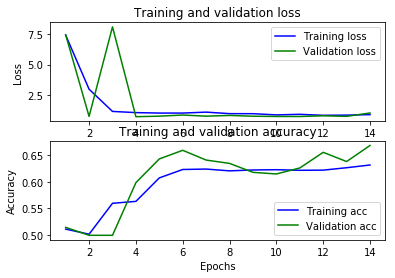

In [25]:

settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'dense.1.units': 1000,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.5,
    'dense.2.units': 100,
    'dense.2.acti': 'relu',
    'dense.2.dropout': 0.5,
    'dense.3.units': 10,
    'dense.3.acti': 'relu',
    'dense.3.dropout': 0.5,
    'out.acti': 'sigmoid',
    'lr.initial': 0.001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 10,
    'kernel.regularizer': 0.01
}

model = dense_model(input_dim=X_train.shape[1], settings=settings)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [26]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 51.54%


## Create dense on embedded data

Next available file: ./logs/word_embeddings/run_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                800016    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)       

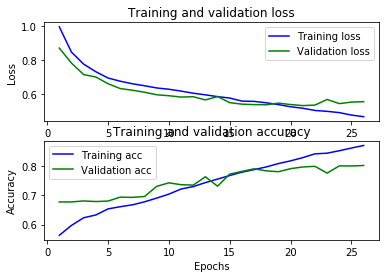

In [27]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': 50,
    'dense.1.units': 16,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.5,
    'dense.2.units': 16,
    'dense.2.acti': 'relu',
    'dense.2.dropout': 0.5,
    'dense.3.units': 16,
    'dense.3.acti': 'relu',
    'dense.3.dropout': 0.5,
    'out.acti': 'sigmoid',
    'lr.initial': 0.0001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = embedding_flatten_model(input_dim=X_train.shape[1], settings=settings)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
            # y_test, y_test, y_test, y_test
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [29]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/embedded_dense/model', '.h5'))

Next available file: ./models/Embedded_models/embedded_dense/model_0.h5


In [30]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 52.28%


## Create lstm model

Next available file: ./logs/word_embeddings/run_2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)           

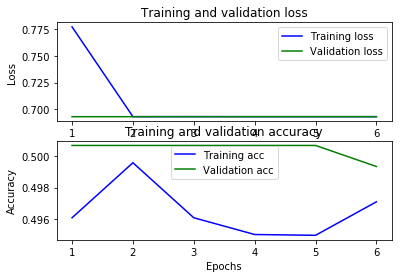

In [31]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': 100,
    'lstm.1.units': 32,
    'lstm.1.dropout': 0.2,
    'dense.1.units': 16,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.2,
    'dense.2.units': 16,
    'dense.2.acti': 'relu',
    'dense.2.dropout': 0.2,
    'out.acti': 'sigmoid',
    'lr.initial': 0.001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = lstm_model(input_dim=X_train.shape[1], settings=settings)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
            # y_test, y_test, y_test, y_test
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)


In [32]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/embedded_lstm/model', '.h5'))

Next available file: ./models/Embedded_models/embedded_lstm/model_0.h5


In [33]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 50.00%


## Bidirectional LSTM

Next available file: ./logs/word_embeddings/run_3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)          

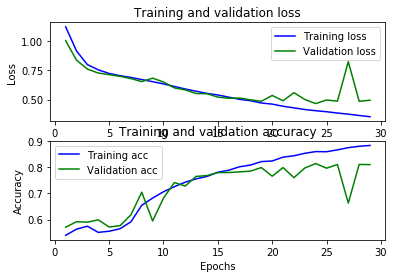

In [34]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': 100,
    'lstm.1.units': 32,
    'lstm.1.dropout': 0.2,
    'dense.1.units': 16,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.2,
    'dense.2.units': 16,
    'dense.2.acti': 'relu',
    'dense.2.dropout': 0.2,
    'out.acti': 'sigmoid',
    'lr.initial': 0.0001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = bidirectional_lstm_model(input_dim=X_train.shape[1], settings=settings)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [35]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/embedded_bidirectional_lstm/model', '.h5'))

Next available file: ./models/Embedded_models/embedded_bidirectional_lstm/model_0.h5


In [36]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 52.14%


## CNN

Next available file: ./logs/word_embeddings/run_4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 969, 32)           102432    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 193, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 162, 32)           32800     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
global_average_pooling1d_1

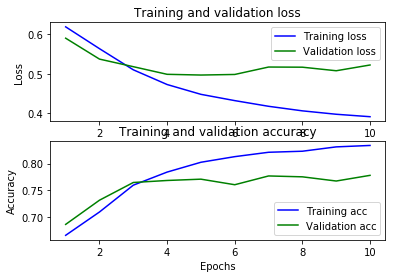

In [37]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': 100,
    'cnn.1.units': 32,
    'cnn.1.len': 32,
    'cnn.1.acti': 'relu',
    'pooling.1.len': 5,
    'cnn.2.units': 32,
    'cnn.2.len': 32,
    'cnn.2.acti': 'relu',
    'pooling.2.len': 5,
    'global.1.units': 16,
    'global.1.dropout': 0.4,
    'out.acti': 'sigmoid',
    'lr.initial': 0.0001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = cnn(input_dim=X_train.shape[1], settings=settings)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [38]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/embedded_cnn/model', '.h5'))

Next available file: ./models/Embedded_models/embedded_cnn/model_0.h5


In [39]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 54.42%


## CNN and LSTM mixed

Next available file: ./logs/word_embeddings/run_5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 969, 32)           102432    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 193, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)          

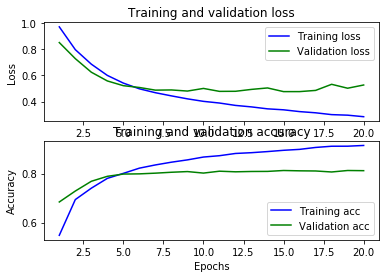

In [40]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': 100,
    'cnn.1.units': 32,
    'cnn.1.len': 32,
    'cnn.1.acti': 'relu',
    'pooling.1.len': 5,
    'lstm.1.units': 32,
    'lstm.1.dropout': 0.4,
    'dense.1.units': 16,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.4,
    'out.acti': 'sigmoid',
    'lr.initial': 0.0001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = cnn_lstm_model(input_dim=X_train.shape[1], settings=settings)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [41]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/embedded_cnn_lstm/model', '.h5'))

Next available file: ./models/Embedded_models/embedded_cnn_lstm/model_0.h5


In [42]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 50.80%


## Compare pretrained embedded layer with self learned layer

In [50]:
# Get Glove weights
glove_dir = './/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),'r', encoding='utf8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [51]:
# build embedding matrix
embedding_dim = 100
 # Train Tokenizer
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(serie_texts)
word_index=tok.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.50269002,  0.056798  ,  0.21261001, ...,  0.085045  ,
         0.60573   , -0.73576999],
       [ 0.70137   , -0.51065999,  0.16745   , ...,  0.57358998,
        -0.15755001, -0.23511   ]])

Next available file: ./logs/word_embeddings/run_10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 969, 32)           102432    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 193, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)         

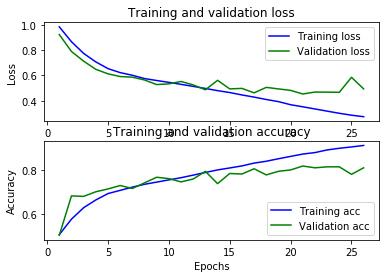

In [55]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': embedding_dim,
    'cnn.1.units': 32,
    'cnn.1.len': 32,
    'cnn.1.acti': 'relu',
    'pooling.1.len': 5,
    'lstm.1.units': 32,
    'lstm.1.dropout': 0.2,
    'dense.1.units': 16,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.2,
    'out.acti': 'sigmoid',
    'lr.initial': 0.0001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = cnn_lstm_model(input_dim=X_train.shape[1], settings=settings)

#Freeze layer
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=False

model.compile(
    optimizer=RMSprop(lr=settings['lr.initial']),
    loss={
        'main_output': 'binary_crossentropy',
    },
    loss_weights={
        'main_output': 1., 
    },
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    [
        y_train, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        X_test, 
        [
            y_test, 
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [56]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/pretrained_embedded_cnn_lstm/model', '.h5'))

Next available file: ./models/Embedded_models/pretrained_embedded_cnn_lstm/model_0.h5


In [57]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 54.22%


## Train CNN-LSTM-Model on Pan

Next available file: ./logs/word_embeddings/run_7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 969, 32)           102432    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 193, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)          

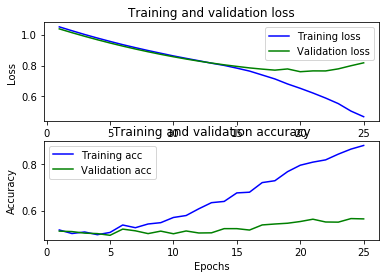

In [47]:
settings = {
    'folder': aatm_support.next_file('./logs/word_embeddings/run', ''),
    'embedding.units': 100,
    'cnn.1.units': 32,
    'cnn.1.len': 32,
    'cnn.1.acti': 'relu',
    'pooling.1.len': 5,
    'lstm.1.units': 32,
    'lstm.1.dropout': 0.4,
    'dense.1.units': 16,
    'dense.1.acti': 'relu',
    'dense.1.dropout': 0.4,
    'out.acti': 'sigmoid',
    'lr.initial': 0.0001,
    'epochs': 200,
    'batch_size': 32,
    'early_stop.monitor': 'val_loss',
    'early_stop.min_delta': 0.001,
    'early_stop.patience': 5,
    'kernel.regularizer': 0.01
}

model = cnn_lstm_model(input_dim=pan_text.shape[1], settings=settings)

history = model.fit(
    pan_text,
    [
        pan_label, 
    ],
    batch_size=settings['batch_size'],
    epochs=settings['epochs'], 
    validation_data=(
        val_text, 
        [
            val_label, 
        ],
    ),
    callbacks=[
        EarlyStopping(
            monitor=settings['early_stop.monitor'], 
            min_delta=settings['early_stop.min_delta'],
            patience=settings['early_stop.patience']
        ), 
        TensorBoardLogger(
            log_dir=settings['folder'], 
            histogram_freq=0,
            batch_size=settings['batch_size'], 
            write_graph=False,
            settings_str_to_log=json.dumps(settings, ensure_ascii=False)
        )
    ]
)

draw_history(history)

In [48]:
# Run this to save a model after training
model.save(aatm_support.next_file('./models/Embedded_models/pan_embedding_cnn_lstm/model', '.h5'))

Next available file: ./models/Embedded_models/pan_embedding_cnn_lstm/model_1.h5


In [49]:
# Test model on pan2018 data
scores = model.evaluate(val_text, val_label, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 56.43%
